In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/output_pr/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('Rod', 'NA'), ('and', 'NA'), ('cone', 'NA'), ('photoreceptors', 'NA'), ('subserve', 'NA'), ('vision', 'NA'), ('under', 'NA'), ('dim', 'NA'), ('and', 'NA'), ('bright', 'NA'), ('light', 'NA'), ('conditions', 'NA'), ('respectively', 'NA'), ('The', 'NA'), ('differences', 'NA'), ('in', 'NA'), ('their', 'NA'), ('function', 'NA'), ('are', 'NA'), ('thought', 'NA'), ('to', 'NA'), ('stem', 'NA'), ('from', 'NA'), ('their', 'NA'), ('different', 'NA'), ('gene', 'NA'), ('expression', 'NA'), ('patterns', 'NA'), ('morphologies', 'NA'), ('and', 'NA'), ('synaptic', 'NA'), ('connectivities', 'NA'), ('In', 'NA'), ('this', 'NA'), ('study', 'NA'), ('we', 'NA'), ('have', 'NA'), ('examined', 'NA'), ('the', 'NA'), ('photoreceptor', 'NA'), ('cells', 'NA'), ('of', 'NA'), ('the', 'NA'), ('retinal', 'NA'), ('degeneration', 'NA'), ('7', 'NA'), ('rd7', 'NA'), ('mutant', 'NA'), ('mouse', 'NA'), ('a', 'NA'), ('model', 'NA'), ('for', 'NA'), ('the', 'NA'), ('human', 'NA'), ('enhanced', 'NA'), ('Scone', 'NA'), ('syndro

546

In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['0'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['NR2E3']
print tag2idx["NA"]

6673
487


In [7]:
print tag2idx

{'PR:000003199': 1, 'PR:000015706': 2, 'PR:000010246': 3, 'PR:000015394': 4, 'PR:000015393': 5, 'PR:000010249': 6, 'PR:000015399': 7, 'PR:000007232': 8, 'PR:000025662': 9, 'PR:000007924': 10, 'PR:000007928': 11, 'PR:000017370': 12, 'PR:000013057': 13, 'PR:000013056': 14, 'PR:000017387': 479, 'PR:000013058': 15, 'PR:000007234': 188, 'PR:000011441': 17, 'PR:000013672': 18, 'PR:000016579': 19, 'PR:000008680': 279, 'PR:000013829': 21, 'PR:000013820': 22, 'PR:000005257': 23, 'PR:000013947': 24, 'PR:000006592': 25, 'PR:000015305': 26, 'PR:000006606': 27, 'PR:000006607': 28, 'PR:000009064': 29, 'PR:000006608': 30, 'PR:000007241': 31, 'PR:000010242': 32, 'PR:000009365': 33, 'PR:000001856': 34, 'PR:000010875': 36, 'PR:000008260': 37, 'PR:000008610': 38, 'PR:000014615': 39, 'PR:000009218': 40, 'PR:000006506': 41, 'PR:000006853': 42, 'PR:000006852': 43, 'PR:000006855': 44, 'PR:000006854': 45, 'PR:000006857': 46, 'PR:000006856': 47, 'PR:000010213': 475, 'PR:000010873': 48, 'PR:000003457': 49, 'PR:

In [8]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=-1)

In [10]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [11]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["NA"])

In [12]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [13]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [14]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [15]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(1667, 75) (715, 75) (1667, 75, 547) (715, 75, 547)


In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.25))(model)  # variational biLSTM
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [17]:
model = Model(input, out)

In [18]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [19]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           1809500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 547)           109947    
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 547)           600059    
Total params: 2,680,306
Trainable params: 2,680,306
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 1667 samples, validate on 715 samples
Epoch 1/15
1667/1667 [==============================] - 35s 21ms/step - loss: 0.7937 - viterbi_acc: 0.9315 - val_loss: 0.3018 - val_viterbi_acc: 0.9726
Epoch 2/15
1667/1667 [==============================] - 34s 20ms/step - loss: 0.2817 - viterbi_acc: 0.9721 - val_loss: 0.2678 - val_viterbi_acc: 0.9726
Epoch 3/15
1667/1667 [==============================] - 34s 20ms/step - loss: 0.2276 - viterbi_acc: 0.9721 - val_loss: 0.2323 - val_viterbi_acc: 0.9726
Epoch 4/15
1667/1667 [==============================] - 33s 20ms/step - loss: 0.1733 - viterbi_acc: 0.9727 - val_loss: 0.1685 - val_viterbi_acc: 0.9731
Epoch 5/15
1667/1667 [==============================] - 34s 20ms/step - loss: 0.1460 - viterbi_acc: 0.9729 - val_loss: 0.1521 - val_viterbi_acc: 0.9737
Epoch 6/15
1667/1667 [==============================] - 34s 20ms/step - loss: 0.1339 - viterbi_acc: 0.9733 - val_loss: 0.1483 - val_viterbi_acc: 0.9738
Epoch 7/15
1667/1667 [===================

In [21]:
hist = pd.DataFrame(history.history)

In [22]:
print hist

        loss  val_loss  val_viterbi_acc  viterbi_acc
0   0.793689  0.301816         0.972606     0.931550
1   0.281708  0.267781         0.972606     0.972086
2   0.227633  0.232255         0.972606     0.972086
3   0.173341  0.168482         0.973072     0.972661
4   0.146019  0.152096         0.973650     0.972917
5   0.133916  0.148342         0.973818     0.973325
6   0.124117  0.141895         0.973874     0.973829
7   0.118347  0.140987         0.975142     0.974237
8   0.112873  0.142537         0.975012     0.974749
9   0.109124  0.137439         0.975403     0.975125
10  0.104389  0.142590         0.975403     0.975581
11  0.099893  0.134830         0.976802     0.976357
12  0.094893  0.138760         0.977193     0.977365
13  0.089546  0.136564         0.977641     0.978708
14  0.082375  0.126286         0.979469     0.980596


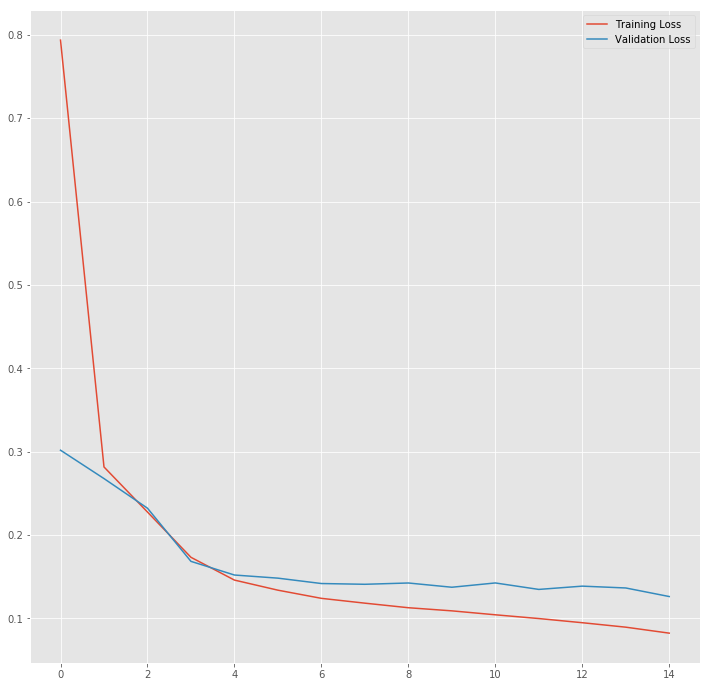

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

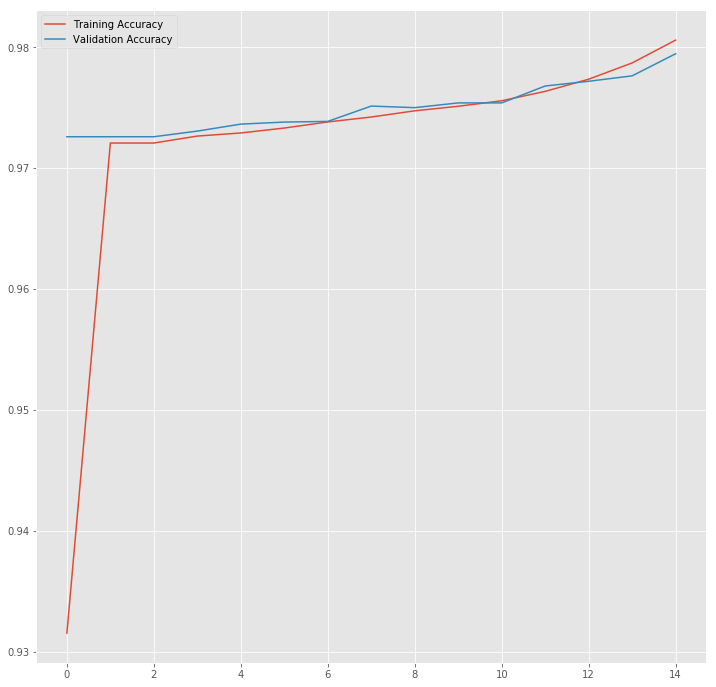

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
for i in range(len(predicted[:20])):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    predicted_val.append(p_tmp)
    true.append(t_tmp)

    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 297 487 487
 487 487 487 487 487 487 487 487 487  61 487 487 487 487 487 487 487 487
 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487
 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487
 487 487 487]
[487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 130 487 487
 487 487 487 487 487 487 487 487 487 130 487 487 487 487 487 487 487 487
 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487
 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487 487
 487 487 487]
['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'PR:000003573', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'PR:000004122', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
H              : PR:000014441 PR:000014441
In             : PR:000014441 PR:000014441
addition       : PR:000014441 PR:000014441
to             : PR:000014441 PR:000014441
a              : PR:000014441 PR:000014441
large          : PR:000014441 PR:000014441
area           : PR:000014441 PR:000014441
of             : PR:000014441 PR:000014441
γH2AX         : PR:000014441 PR:000014441
staining       : PR:000014441 PR:000014441
arrow          : PR:000014441 PR:000014441
over           : PR:000014441 PR:000014441
the            : PR:000014441 PR:000014441
XY             : PR:000014441 PR:000014441
body           : PR:000014441 PR:000014441
there          : PR:000014441 PR:000014441
is             : PR:000014441 PR:000014441
extensive      : PR:000014441 PR:000014441
autosomal      : PR:000014441 PR:000014441
H2AX           : PR:000009863 PR:000007551
phosphorylation: PR:000014441 PR:000014441
arrows         : PR:000014441 PR:000014441
NaKATPase      : PR:000014

In [27]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t))
}
)


In [28]:
df.to_csv('../data/results/PR_LSTM_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/PR_LSTM_Based.tsv ../data/validation_data/PR_AllSubsumers.tsv

Mean semantic similarity:  0.534
